In [504]:
#Importing libraries
import numpy as np
import pandas as pd

import os
import json
import shap
import dill
import matplotlib.pyplot as plt
from collections import Counter
from PIL import  Image
%matplotlib inline

import pandas as pd
import seaborn as sns #visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

import xgboost as xgb
import catboost as catb
import lightgbm as lgbm
from imblearn.over_sampling import RandomOverSampler, ADASYN, BorderlineSMOTE, SMOTE

from scipy.stats import shapiro, probplot, ttest_ind, mannwhitneyu, chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, scorer, log_loss
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score, cohen_kappa_score
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import ClassTransformation

import statsmodels.api as sm
from yellowbrick.classifier import DiscriminationThreshold
from pylab import rcParams

rcParams['figure.figsize'] = 8, 5
pd.set_option('display.max_columns', 500)
plt.style.use('seaborn-whitegrid')

# Домашнее задание

1. Скачать любой понравившийся вам датасет с UCI repository(можете даже свой какой-то взять) и сразу же разделите его на тренировочную и тестовую выборки. Тестовую выборку сохраните на диск и больше не трогайте.

In [6]:
#скачал датасет отсюда https://www.kaggle.com/CooperUnion/cardataset
df = pd.read_csv("hw8_data.csv")

In [7]:
df.shape

(11914, 16)

In [8]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

In [36]:
[x for x in features if x not in num_features]

['Make',
 'Model',
 'Engine Fuel Type',
 'Transmission Type',
 'Driven_Wheels',
 'Market Category',
 'Vehicle Size',
 'Vehicle Style']

In [37]:
target = 'MSRP'
features = list(df.columns[:15])
num_features = list(df_train.corr().columns)
dum_features = [x for x in features if x not in num_features]
y = df[target]
X = df[features]

In [351]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [352]:
#save test
X_test.to_csv("hw8_X_test.csv", index=None)
y_test.to_csv("hw8_y_test.csv", index=None)
#save train
X_train.to_csv("hw8_X_train.csv", index=None)
y_train.to_csv("hw8_y_train.csv", index=None)

In [353]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train.shape

(8935, 16)

2. Провести EDA

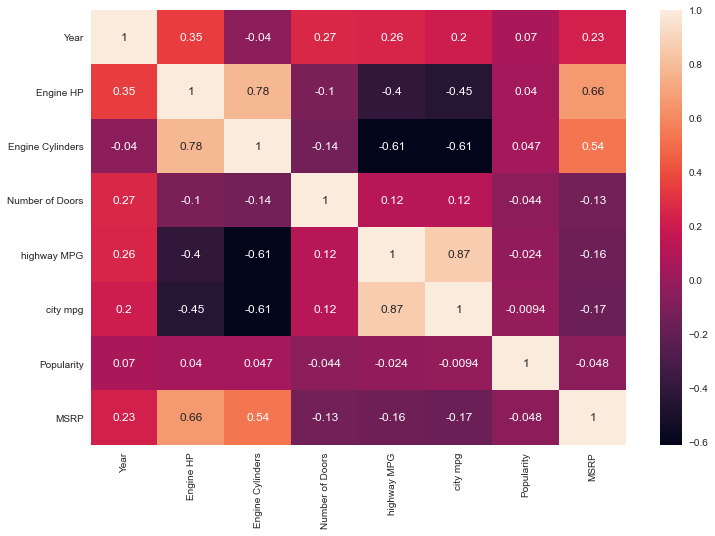

In [24]:
# Корреляция Пирсона
rcParams['figure.figsize'] = 12, 8
sns.heatmap(df_train.corr(), annot=True)

Коррелируют с целевой переменной больше всего:

- Мощность авто Engine HP
- Кол-во цилиндров Engine Cylinders

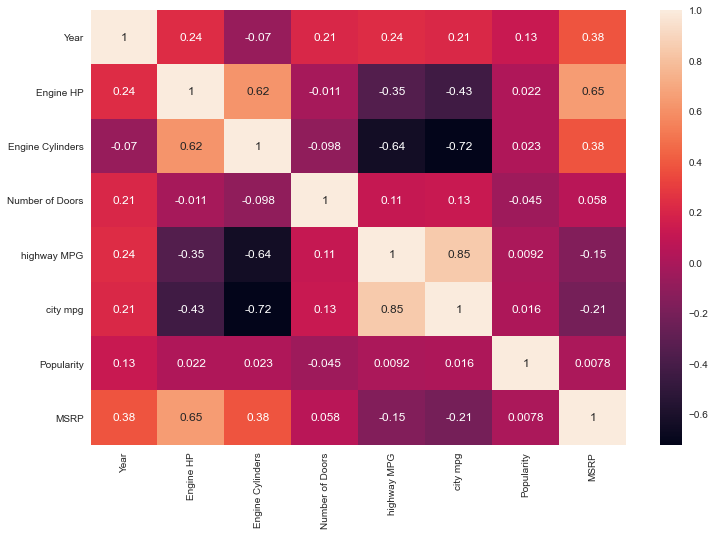

In [33]:
#Корреляция по Кендаллу
sns.heatmap(df_train.corr(method='kendall'), annot=True)

Видна также значимая корреляция по Кендаллу между годом выпуска и ценой

Посмотрим на числовые признаки:

In [25]:
def extend_describe_for_num_values(df, col_lst, target_name):
    #Функция возвращает доп.данные по признакам с таблицой describe: 
    # - дисперсию
    # - кол-во пустых значений
    # - кол-во уникальных значений
    # - корреляцию Пирсона с целевым признаком
    # - p-value по тесту Шапиро о нормальности распределения
    # - p-value по критерию Манна-Уитни о равных значениях мат. ожидайния между разными значениями классов целевого признака
    
    df_describe = df[col_lst].describe()
    df_desc_add = pd.DataFrame(columns=col_lst)
    for _ in range(5):
        df_desc_add = df_desc_add.append(pd.Series(), ignore_index=True)
    
    
    for v in col_lst:
        df_desc_add[v].iloc[[0]] = np.var(df[v])
        df_desc_add[v].iloc[[1]] = df[df[v].isnull()].shape[0]
        df_desc_add[v].iloc[[2]] = df[v].nunique()
        df_notna = df.loc[df[v].notna()]
        shapiro_p_value = shapiro(df_notna[v])[1]
        df_desc_add[v].iloc[[3]] = shapiro_p_value
        if shapiro_p_value < 0.05:
            v_target_0 = df_notna.loc[df_notna[target_name]==0, v]
            v_target_1 = df_notna.loc[df_notna[target_name]==1, v]
            df_desc_add[v].iloc[[4]] = mannwhitneyu(v_target_0, v_target_1)[1]
    
    df_corr = pd.DataFrame(df[col_lst + [target_name]].corr().iloc[:-1, -1]).T

    df_desc_add.rename(index={0:'var', 1:'null', 2:'nunique', 3:'shapiro p-value', 4:'mannw p-value'}, inplace=True)
    df_corr.rename(index={target_name:'corr'}, inplace=True)
    
    df2 = pd.concat([df_describe, df_desc_add, df_corr])
    
    return df2

In [31]:
extend_describe_for_num_values(df_train, num_features, target)

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,MSRP
count,8935,8886,8915,8929,8935,8935,8935,8935
mean,2010.43,249.404,5.62524,3.44294,26.6542,19.7126,1568.28,40692.4
std,7.53745,109.654,1.77892,0.877791,8.8661,8.63955,1453.22,59578.5
min,1990,55,0,2,12,8,2,2000
25%,2007,170,4,2,22,16,549,21077.5
50%,2015,225,6,4,26,18,1385,29990
75%,2016,302,6,4,30,22,2009,42492.5
max,2017,1001,16,4,354,137,5657,2.0659e+06
var,56.8068,12022.6,3.16421,0.770431,78.5989,74.6335,2.11163e+06,3.54919e+09
null,0,49,20,6,0,0,0,0


- Все распределения не нормальные (Значение Критерия Шапиро-Уилка ниже порогового 𝑝 - 𝑣𝑎𝑙𝑢𝑒<0.05 )
- Есть пропуски в Engine HP, Engine Cylinders, Number of Doors, которые нужно обработать

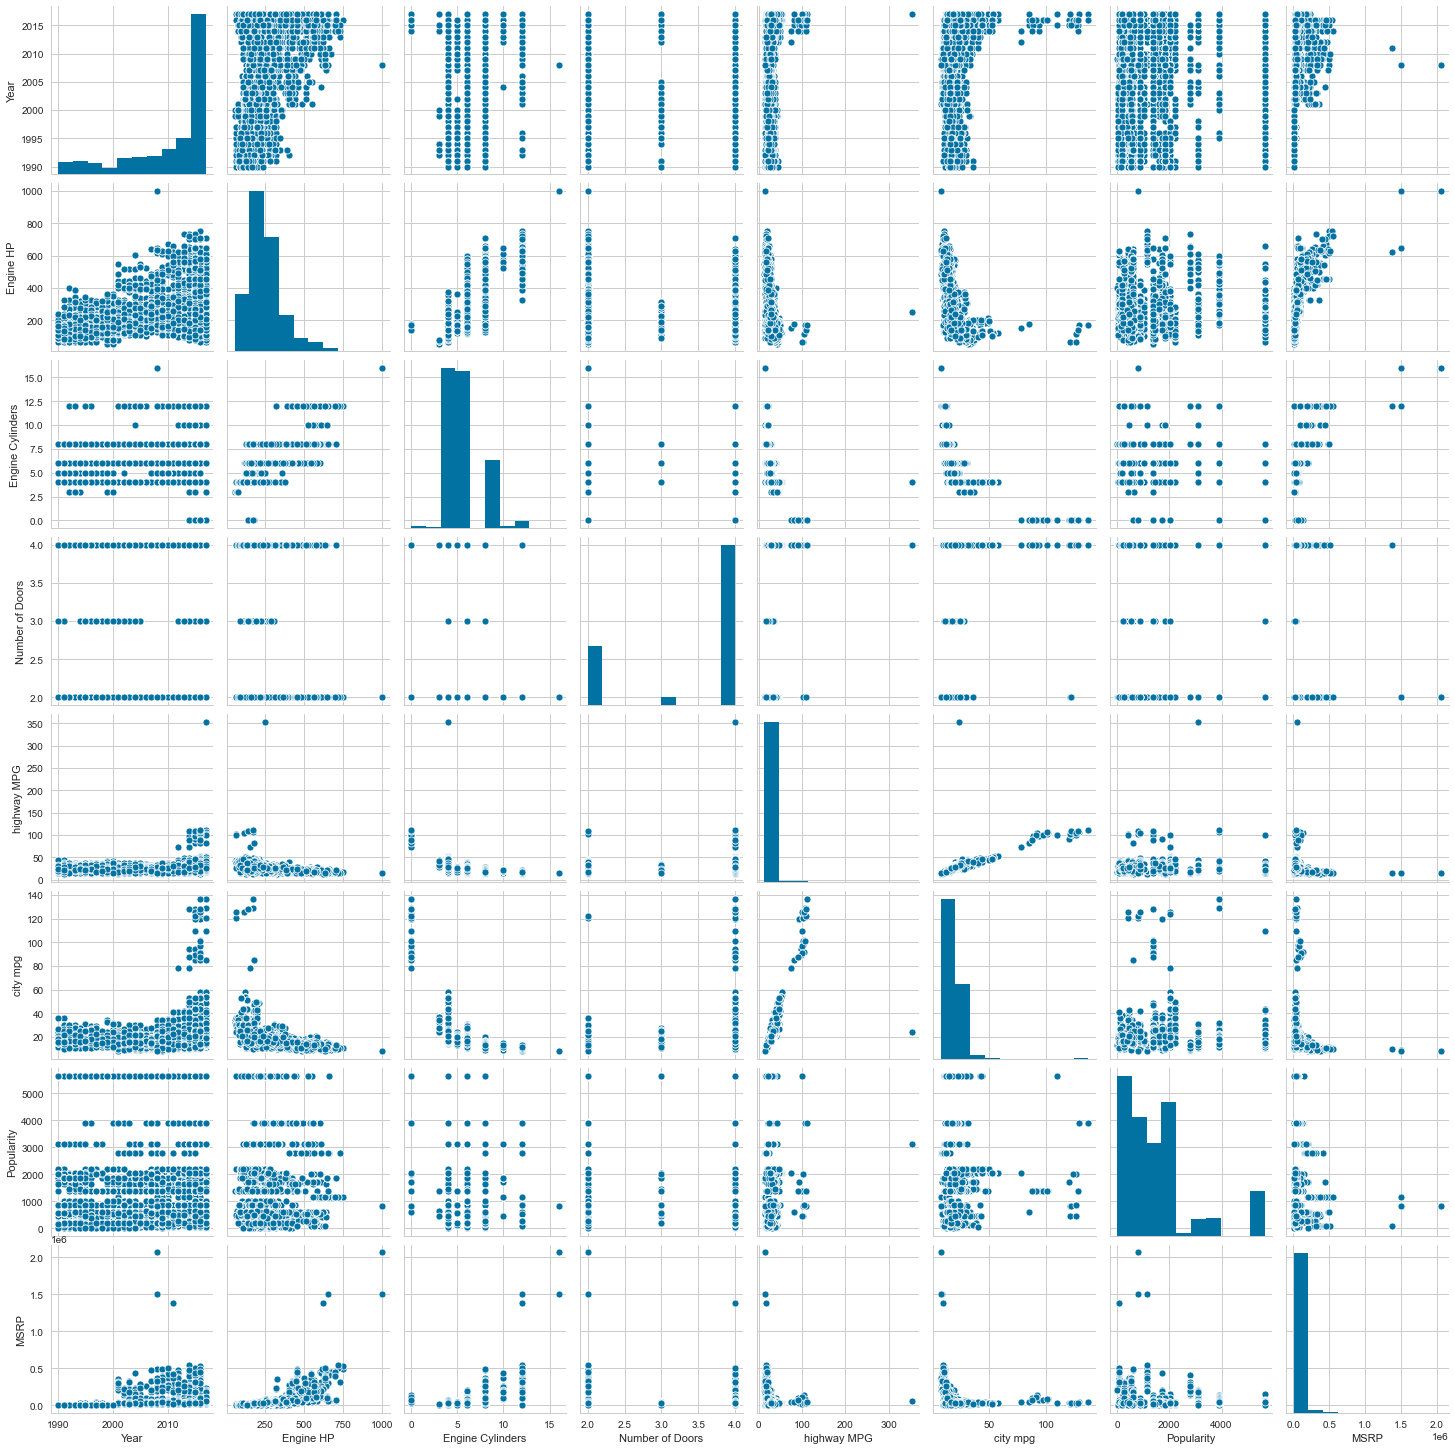

In [32]:
sns_plot = sns.pairplot(df_train[num_features])
# sns_plot.savefig('pairplot.png')

Посмотрим на категориальные признаки

In [34]:
def extend_describe_for_dummies_values(df, col_lst, target_name, col_for_count):
    """Функция считает и выводит:
    кол-во всего значений
    кол-во уникальных значений
    кол-во пропусков
    p-value для критерия Хи-Квадрат Пирсона
    """
    df_desc = pd.DataFrame(columns=col_lst)
    n = df.shape[0]
    
    for _ in range(5):
        df_desc = df_desc.append(pd.Series(), ignore_index=True)
    
    for v in col_lst:
        df_desc[v].iloc[[0]] = df[v].count()
        df_desc[v].iloc[[1]] = len(df[v].unique())
        
        null_amount = df.loc[df[v].isnull()].shape[0]
        df_desc[v].iloc[[2]] = null_amount
        df_desc[v].iloc[[3]] = round((1-null_amount/n) * 100, 2)
        
        #Критерий Хи-Квадрат для определения p-value
        table = df.pivot_table(values=col_for_count, index=v, columns=target_name, aggfunc='count')
        table.fillna(0, inplace=True)
        if table.shape[0] > 0:
            chi2, p, dof, expected = chi2_contingency(table, correction=False)
        else:
            p='-'
        df_desc[v].iloc[[4]] = p

    df_desc.rename(index={0:'count', 1:'uniques', 2:'null', 3:'fullness', 4:'p-value'}, inplace=True)

    return df_desc

In [38]:
extend_describe_for_dummies_values(df_train, dum_features, target, 'Year')

,Make,Model,Engine Fuel Type,Transmission Type,Driven_Wheels,Market Category,Vehicle Size,Vehicle Style
count,8935,8935,8932,8935,8935,6137,8935,8935
uniques,48,896,11,5,4,70,3,16
null,0,0,3,0,0,2798,0,0
fullness,100,100,99.97,100,100,68.68,100,100
p-value,0,0,0,0.000177973,5.47363e-84,0,4.27721e-54,4.31388e-29


- У всех признаков p-value < 0.05, а значит их значения по разному влияют на целевую переменную.
- Есть пропуски в Engine Fuel Type, их нужно обработать
- Пропусков в Market Category очень много - этот признак возможно придется отбросить

In [57]:
df_train['Vehicle Size'].value_counts()

Compact    3574
Midsize    3283
Large      2078
Name: Vehicle Size, dtype: int64

In [58]:
df_train['Vehicle Style'].value_counts()

Sedan                  2334
4dr SUV                1850
Coupe                   873
Convertible             599
4dr Hatchback           535
Crew Cab Pickup         506
Extended Cab Pickup     465
Wagon                   439
2dr Hatchback           395
Passenger Minivan       317
Regular Cab Pickup      275
2dr SUV                 107
Passenger Van            92
Cargo Van                70
Cargo Minivan            55
Convertible SUV          23
Name: Vehicle Style, dtype: int64

Посмотрим на значения категориальных признаков с пропусками:

In [40]:
df_train['Engine Fuel Type'].value_counts()

regular unleaded                                5357
premium unleaded (required)                     1555
premium unleaded (recommended)                  1134
flex-fuel (unleaded/E85)                         660
diesel                                           117
electric                                          45
flex-fuel (premium unleaded required/E85)         35
flex-fuel (premium unleaded recommended/E85)      22
flex-fuel (unleaded/natural gas)                   5
natural gas                                        2
Name: Engine Fuel Type, dtype: int64

In [49]:
list(df_train['Market Category'].value_counts().index)

['Crossover',
 'Luxury',
 'Flex Fuel',
 'Luxury,Performance',
 'Hatchback',
 'Performance',
 'Crossover,Luxury',
 'Luxury,High-Performance',
 'Exotic,High-Performance',
 'Hatchback,Performance',
 'Factory Tuner,Luxury,High-Performance',
 'High-Performance',
 'Hybrid',
 'Crossover,Luxury,Performance',
 'Factory Tuner,High-Performance',
 'Factory Tuner,Performance',
 'Flex Fuel,Performance',
 'Diesel',
 'Hatchback,Hybrid',
 'Exotic,Luxury,High-Performance',
 'Crossover,Performance',
 'Crossover,Hatchback',
 'Crossover,Flex Fuel',
 'Luxury,Hybrid',
 'Exotic,Factory Tuner,Luxury,High-Performance',
 'Hatchback,Luxury',
 'Diesel,Luxury',
 'Crossover,Hybrid',
 'Hatchback,Luxury,Performance',
 'Exotic,Luxury,Performance',
 'Crossover,Luxury,Diesel',
 'Flex Fuel,Luxury',
 'Flex Fuel,Luxury,High-Performance',
 'Factory Tuner,Luxury,Performance',
 'Crossover,Factory Tuner,Luxury,High-Performance',
 'Flex Fuel,Luxury,Performance',
 'Hatchback,Factory Tuner,Performance',
 'Crossover,Luxury,Hybrid',

3. Сделать feature engineering. При этом постарайтесь «завернуть» ваш код для преобразования данных в классы или функции (пример Transformer как в ноутбуке)

Заполним пропуски в признаках:

In [322]:
#Общая функция обработки пустых значений для трансформера
def group_and_get_max_column_for_transform(df, group_cols, get_max_col, count_col):
    """
    Заполняет пропуски значений максимальным по кол-ву значений в группировке
    group_cols - список показателей для группировки
    get_max_col - показатель, который нужно дозаполнить
    count_col - показатель, по которому будем считать кол-во элементов
    на выходе датафрейм с признаками group_cols и значением признака get_max_col для подстановки
    """
    all_group_cols = group_cols + [get_max_col]
    group_1 = df.groupby(all_group_cols, 
                    as_index=False).agg({count_col: "count"})
    group_2 = group_1.groupby(group_cols, 
                    as_index=False).agg({count_col: "max"})
    
    final_cols = group_cols + [count_col]
    
    final_group = pd.merge(group_2, group_1, on=final_cols, how='left').rename(columns={get_max_col: 'max_value'})
    final_group.drop(count_col, axis=1, inplace=True)
    final_group.drop_duplicates(group_cols, keep='first', inplace=True)
    
    return final_group

In [408]:
class Fillna_max_value_by_group(BaseEstimator, TransformerMixin):
    def __init__(self, group_cols, get_max_col, count_col):
        self.group_cols = group_cols
        self.get_max_col = get_max_col
        self.count_col = count_col

    def fit(self, X, y=None):
        self.final_group = group_and_get_max_column_for_transform(X, self.group_cols, self.get_max_col, self.count_col)
        return self

    def transform(self, X):
        X2 = pd.merge(X, self.final_group, on=self.group_cols, how='left')
        X2.loc[X2[self.get_max_col].isnull(), self.get_max_col] = X2.loc[X2[self.get_max_col].isnull(), 'max_value']
        X2.drop('max_value', axis=1, inplace=True)
        
        return X2

In [406]:
class Fillna_unknown(BaseEstimator, TransformerMixin):
    #оставшимся значениям присвоим значение 'unknown'
    def __init__(self, get_max_col):
        self.get_max_col = get_max_col
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X2 = X.copy()
        X2[self.get_max_col].fillna('unknown', inplace=True)
        return X2

In [407]:
class Fillna_max_value_by_feat(BaseEstimator, TransformerMixin):
    #оставшимся значениям присвоим значение 'unknown'
    def __init__(self, get_max_col):
        self.get_max_col = get_max_col
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X2 = X.copy()
        X2[self.get_max_col].fillna(X2.groupby(self.get_max_col).size().sort_values(ascending=False).index[0], inplace=True)
        return X2

In [402]:
engine_fuel_type_fillna =  Pipeline([
                ('fillna', Fillna_max_value_by_group(['Make', 'Model'], 'Engine Fuel Type', 'Year')),
                ('fill_unknown', Fillna_unknown('Engine Fuel Type'))
            ])

engine_fuel_type_fillna.fit_transform(X_train)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity
0,Lotus,Evora,2013,premium unleaded (required),276.0,6.0,MANUAL,rear wheel drive,2.0,"Exotic,High-Performance",Compact,Coupe,26,18,613
1,Maserati,GranTurismo,2016,premium unleaded (required),454.0,8.0,AUTOMATIC,rear wheel drive,2.0,"Exotic,Factory Tuner,Luxury,High-Performance",Large,Coupe,21,13,238
2,Toyota,Prius c,2014,regular unleaded,99.0,4.0,AUTOMATIC,front wheel drive,4.0,"Hatchback,Hybrid",Compact,4dr Hatchback,46,53,2031
3,Alfa Romeo,4C,2015,premium unleaded (required),237.0,4.0,AUTOMATED_MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Convertible,34,24,113
4,Volkswagen,GTI,2012,premium unleaded (recommended),200.0,4.0,MANUAL,front wheel drive,4.0,"Hatchback,Performance",Compact,4dr Hatchback,31,21,873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8930,Toyota,Venza,2014,regular unleaded,181.0,4.0,AUTOMATIC,front wheel drive,4.0,Crossover,Midsize,Wagon,26,20,2031
8931,Pontiac,G6,2009,flex-fuel (unleaded/E85),219.0,6.0,AUTOMATIC,front wheel drive,4.0,Flex Fuel,Midsize,Sedan,26,17,210
8932,Volkswagen,Golf GTI,2016,premium unleaded (recommended),220.0,4.0,AUTOMATED_MANUAL,front wheel drive,2.0,"Hatchback,Performance",Compact,2dr Hatchback,33,25,873
8933,Saab,9-5,2009,premium unleaded (recommended),260.0,4.0,AUTOMATIC,front wheel drive,4.0,"Luxury,Performance",Midsize,Wagon,27,17,376


In [355]:
market_cat_fillna =  Pipeline([
                ('fillna1', Fillna_max_value_by_group(['Make', 'Model'], 'Market Category', 'Year')),
                ('fillna2', Fillna_max_value_by_group(['Make', 'Vehicle Style', 'Vehicle Size'], 'Market Category', 'Year')),
                ('fill_unknown', Fillna_unknown('Market Category'))
            ])

market_cat_fillna.fit_transform(X_train)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity
0,Lotus,Evora,2013,premium unleaded (required),276.0,6.0,MANUAL,rear wheel drive,2.0,"Exotic,High-Performance",Compact,Coupe,26,18,613
1,Maserati,GranTurismo,2016,premium unleaded (required),454.0,8.0,AUTOMATIC,rear wheel drive,2.0,"Exotic,Factory Tuner,Luxury,High-Performance",Large,Coupe,21,13,238
2,Toyota,Prius c,2014,regular unleaded,99.0,4.0,AUTOMATIC,front wheel drive,4.0,"Hatchback,Hybrid",Compact,4dr Hatchback,46,53,2031
3,Alfa Romeo,4C,2015,premium unleaded (required),237.0,4.0,AUTOMATED_MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Convertible,34,24,113
4,Volkswagen,GTI,2012,premium unleaded (recommended),200.0,4.0,MANUAL,front wheel drive,4.0,"Hatchback,Performance",Compact,4dr Hatchback,31,21,873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8930,Toyota,Venza,2014,regular unleaded,181.0,4.0,AUTOMATIC,front wheel drive,4.0,Crossover,Midsize,Wagon,26,20,2031
8931,Pontiac,G6,2009,flex-fuel (unleaded/E85),219.0,6.0,AUTOMATIC,front wheel drive,4.0,Flex Fuel,Midsize,Sedan,26,17,210
8932,Volkswagen,Golf GTI,2016,premium unleaded (recommended),220.0,4.0,AUTOMATED_MANUAL,front wheel drive,2.0,"Hatchback,Performance",Compact,2dr Hatchback,33,25,873
8933,Saab,9-5,2009,premium unleaded (recommended),260.0,4.0,AUTOMATIC,front wheel drive,4.0,"Luxury,Performance",Midsize,Wagon,27,17,376


In [403]:
doors_fillna =  Pipeline([
                ('fillna1', Fillna_max_value_by_group(['Make', 'Model'], 'Number of Doors', 'Year')),
                ('fillna_by_feat1', Fillna_max_value_by_feat('Number of Doors'))
            ])

doors_fillna.fit_transform(X_train)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity
0,Lotus,Evora,2013,premium unleaded (required),276.0,6.0,MANUAL,rear wheel drive,2.0,"Exotic,High-Performance",Compact,Coupe,26,18,613
1,Maserati,GranTurismo,2016,premium unleaded (required),454.0,8.0,AUTOMATIC,rear wheel drive,2.0,"Exotic,Factory Tuner,Luxury,High-Performance",Large,Coupe,21,13,238
2,Toyota,Prius c,2014,regular unleaded,99.0,4.0,AUTOMATIC,front wheel drive,4.0,"Hatchback,Hybrid",Compact,4dr Hatchback,46,53,2031
3,Alfa Romeo,4C,2015,premium unleaded (required),237.0,4.0,AUTOMATED_MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Convertible,34,24,113
4,Volkswagen,GTI,2012,premium unleaded (recommended),200.0,4.0,MANUAL,front wheel drive,4.0,"Hatchback,Performance",Compact,4dr Hatchback,31,21,873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8930,Toyota,Venza,2014,regular unleaded,181.0,4.0,AUTOMATIC,front wheel drive,4.0,Crossover,Midsize,Wagon,26,20,2031
8931,Pontiac,G6,2009,flex-fuel (unleaded/E85),219.0,6.0,AUTOMATIC,front wheel drive,4.0,Flex Fuel,Midsize,Sedan,26,17,210
8932,Volkswagen,Golf GTI,2016,premium unleaded (recommended),220.0,4.0,AUTOMATED_MANUAL,front wheel drive,2.0,"Hatchback,Performance",Compact,2dr Hatchback,33,25,873
8933,Saab,9-5,2009,premium unleaded (recommended),260.0,4.0,AUTOMATIC,front wheel drive,4.0,"Luxury,Performance",Midsize,Wagon,27,17,376


In [404]:
engine_hp_fillna =  Pipeline([
                ('fillna1', Fillna_max_value_by_group(['Make', 'Model'], 'Engine HP', 'Year')),
                ('fillna2', Fillna_max_value_by_group(['Make', 'Vehicle Style', 'Vehicle Size'], 'Engine HP', 'Year')),
                ('fillna3', Fillna_max_value_by_group(['Vehicle Style'], 'Engine HP', 'Year')),
                ('fillna_by_feat2', Fillna_max_value_by_feat('Engine HP'))
            ])

engine_hp_fillna.fit_transform(X_train)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity
0,Lotus,Evora,2013,premium unleaded (required),276.0,6.0,MANUAL,rear wheel drive,2.0,"Exotic,High-Performance",Compact,Coupe,26,18,613
1,Maserati,GranTurismo,2016,premium unleaded (required),454.0,8.0,AUTOMATIC,rear wheel drive,2.0,"Exotic,Factory Tuner,Luxury,High-Performance",Large,Coupe,21,13,238
2,Toyota,Prius c,2014,regular unleaded,99.0,4.0,AUTOMATIC,front wheel drive,4.0,"Hatchback,Hybrid",Compact,4dr Hatchback,46,53,2031
3,Alfa Romeo,4C,2015,premium unleaded (required),237.0,4.0,AUTOMATED_MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Convertible,34,24,113
4,Volkswagen,GTI,2012,premium unleaded (recommended),200.0,4.0,MANUAL,front wheel drive,4.0,"Hatchback,Performance",Compact,4dr Hatchback,31,21,873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8930,Toyota,Venza,2014,regular unleaded,181.0,4.0,AUTOMATIC,front wheel drive,4.0,Crossover,Midsize,Wagon,26,20,2031
8931,Pontiac,G6,2009,flex-fuel (unleaded/E85),219.0,6.0,AUTOMATIC,front wheel drive,4.0,Flex Fuel,Midsize,Sedan,26,17,210
8932,Volkswagen,Golf GTI,2016,premium unleaded (recommended),220.0,4.0,AUTOMATED_MANUAL,front wheel drive,2.0,"Hatchback,Performance",Compact,2dr Hatchback,33,25,873
8933,Saab,9-5,2009,premium unleaded (recommended),260.0,4.0,AUTOMATIC,front wheel drive,4.0,"Luxury,Performance",Midsize,Wagon,27,17,376


In [405]:
engine_cil_fillna =  Pipeline([
                ('fillna1', Fillna_max_value_by_group(['Make', 'Model'], 'Engine Cylinders', 'Year')),
                ('fillna_by_feat3', Fillna_max_value_by_feat('Engine Cylinders'))
            ])

engine_cil_fillna.fit_transform(X_train)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity
0,Lotus,Evora,2013,premium unleaded (required),276.0,6.0,MANUAL,rear wheel drive,2.0,"Exotic,High-Performance",Compact,Coupe,26,18,613
1,Maserati,GranTurismo,2016,premium unleaded (required),454.0,8.0,AUTOMATIC,rear wheel drive,2.0,"Exotic,Factory Tuner,Luxury,High-Performance",Large,Coupe,21,13,238
2,Toyota,Prius c,2014,regular unleaded,99.0,4.0,AUTOMATIC,front wheel drive,4.0,"Hatchback,Hybrid",Compact,4dr Hatchback,46,53,2031
3,Alfa Romeo,4C,2015,premium unleaded (required),237.0,4.0,AUTOMATED_MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Convertible,34,24,113
4,Volkswagen,GTI,2012,premium unleaded (recommended),200.0,4.0,MANUAL,front wheel drive,4.0,"Hatchback,Performance",Compact,4dr Hatchback,31,21,873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8930,Toyota,Venza,2014,regular unleaded,181.0,4.0,AUTOMATIC,front wheel drive,4.0,Crossover,Midsize,Wagon,26,20,2031
8931,Pontiac,G6,2009,flex-fuel (unleaded/E85),219.0,6.0,AUTOMATIC,front wheel drive,4.0,Flex Fuel,Midsize,Sedan,26,17,210
8932,Volkswagen,Golf GTI,2016,premium unleaded (recommended),220.0,4.0,AUTOMATED_MANUAL,front wheel drive,2.0,"Hatchback,Performance",Compact,2dr Hatchback,33,25,873
8933,Saab,9-5,2009,premium unleaded (recommended),260.0,4.0,AUTOMATIC,front wheel drive,4.0,"Luxury,Performance",Midsize,Wagon,27,17,376


Добавим новые признаки:

In [372]:
#Функции расчета разных новых признаков:
def pop_year_coef(df):
    return df['Popularity'].astype('float64') * df['Year'].apply(lambda x: 1-x/2017)

def hp_highway_doors_coef(df):
    return df['highway MPG'].astype('float64') * df['Number of Doors'] / df['Engine HP']

def cil_highway_pop_coef(df):
    return df['highway MPG'].astype('float64') * df['Engine Cylinders'] / df['Popularity']

def cil_pop_year_hp_coef(df):
    return df['pop_year_coef'] * df['Engine Cylinders'] * df['Engine HP']

def hp_cil_highway_doors_coef(df):
    return df['highway MPG'].astype('float64') * df['Engine Cylinders'] * df['Number of Doors'] / df['Engine HP']

In [410]:
class Add_new_feat(BaseEstimator, TransformerMixin):
    #оставшимся значениям присвоим значение 'unknown'
    def __init__(self, new_feat_name, func):
        self.new_feat_name = new_feat_name
        self.func = func
        
    def fit(self, X, y=None):
        self.new_col_value = self.func(X)
        return self

    def transform(self, X):
        X2 = X.copy()
        X2[self.new_feat_name] = self.new_col_value
        return X2

In [373]:
add_new_feat =  Pipeline([
                ('add1', Add_new_feat('pop_year_coef', pop_year_coef)),
                ('add2', Add_new_feat('hp_highway_doors_coef', hp_highway_doors_coef)),
                ('add3', Add_new_feat('cil_highway_pop_coef', cil_highway_pop_coef)),
                ('add4', Add_new_feat('cil_pop_year_hp_coef', cil_pop_year_hp_coef)),
                ('add5', Add_new_feat('hp_cil_highway_doors_coef', hp_cil_highway_doors_coef)),
            ])
add_new_feat.fit_transform(X_train)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,pop_year_coef,hp_highway_doors_coef,cil_highway_pop_coef,cil_pop_year_hp_coef,hp_cil_highway_doors_coef
4264,Lotus,Evora,2013,premium unleaded (required),276.0,6.0,MANUAL,rear wheel drive,2.0,"Exotic,High-Performance",Compact,Coupe,26,18,613,1.215667,0.188406,0.254486,2013.144274,1.130435
5559,Maserati,GranTurismo,2016,premium unleaded (required),454.0,8.0,AUTOMATIC,rear wheel drive,2.0,"Exotic,Factory Tuner,Luxury,High-Performance",Large,Coupe,21,13,238,0.117997,0.092511,0.705882,428.565196,0.740088
7666,Toyota,Prius c,2014,regular unleaded,99.0,4.0,AUTOMATIC,front wheel drive,4.0,"Hatchback,Hybrid",Compact,4dr Hatchback,46,53,2031,3.020823,1.858586,0.090596,1196.245910,7.434343
474,Alfa Romeo,4C,2015,premium unleaded (required),237.0,4.0,AUTOMATED_MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Convertible,34,24,113,0.112048,0.286920,1.203540,106.221120,1.147679
5627,Volkswagen,GTI,2012,premium unleaded (recommended),200.0,4.0,MANUAL,front wheel drive,4.0,"Hatchback,Performance",Compact,4dr Hatchback,31,21,873,2.164105,0.620000,0.142039,1731.284085,2.480000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,Toyota,Venza,2014,regular unleaded,181.0,4.0,AUTOMATIC,front wheel drive,4.0,Crossover,Midsize,Wagon,26,20,2031,3.020823,0.574586,0.051206,2187.075855,2.298343
5191,Pontiac,G6,2009,flex-fuel (unleaded/E85),219.0,6.0,AUTOMATIC,front wheel drive,4.0,Flex Fuel,Midsize,Sedan,26,17,210,0.832920,0.474886,0.742857,1094.457115,2.849315
5390,Volkswagen,Golf GTI,2016,premium unleaded (recommended),220.0,4.0,AUTOMATED_MANUAL,front wheel drive,2.0,"Hatchback,Performance",Compact,2dr Hatchback,33,25,873,0.432821,0.300000,0.151203,380.882499,1.200000
860,Saab,9-5,2009,premium unleaded (recommended),260.0,4.0,AUTOMATIC,front wheel drive,4.0,"Luxury,Performance",Midsize,Wagon,27,17,376,1.491324,0.415385,0.287234,1550.976698,1.661538


In [363]:
#X_train2 = X_train[X_train.corr().columns.to_list()]
X_train2 = X_train.copy()

Построим итоговый пайплайн

In [510]:
def print_regr_model_results(y_train_pred, y_train, y_test_pred=None, y_test=None):
    mae_train = mean_absolute_error(y_train_pred, y_train)
    av_y_train = y_train_pred.mean()
    
    print('R2 score train', r2_score(y_train, y_train_pred))
    print('Mean Absolute Error train', mae_train) 
    print('')
    print('Ср. значение train', av_y_train)
    print(f'Доля MAE в среднем: {round(mae_train/av_y_train*100, 3)}%')
    
    if y_test_pred is not None and y_test is not None:
        mae_test = mean_absolute_error(y_test_pred, y_test)
        av_y_test = y_test_pred.mean()
        
        print('')
        print('R2 score test', r2_score(y_test, y_test_pred))
        print('Mean Absolute Error test', mae_test)
        print('')
        print('Ср. значение test', av_y_test)
        print(f'Доля MAE в среднем: {round(mae_test/av_y_test*100, 3)}%')

In [411]:
pipe = Pipeline([
    ('fillna0', Fillna_max_value_by_group(['Make', 'Model'], 'Engine Fuel Type', 'Year')),
    ('fill_unknown0', Fillna_unknown('Engine Fuel Type')),
    ('fillna1', Fillna_max_value_by_group(['Make', 'Model'], 'Market Category', 'Year')),
    ('fillna2', Fillna_max_value_by_group(['Make', 'Vehicle Style', 'Vehicle Size'], 'Market Category', 'Year')),
    ('fill_unknown1', Fillna_unknown('Market Category')),
    ('fillna3', Fillna_max_value_by_group(['Make', 'Model'], 'Number of Doors', 'Year')),
    ('fillna_by_feat1', Fillna_max_value_by_feat('Number of Doors')),
    ('fillna4', Fillna_max_value_by_group(['Make', 'Model'], 'Engine HP', 'Year')),
    ('fillna5', Fillna_max_value_by_group(['Make', 'Vehicle Style', 'Vehicle Size'], 'Engine HP', 'Year')),
    ('fillna6', Fillna_max_value_by_group(['Vehicle Style'], 'Engine HP', 'Year')),
    ('fillna_by_feat2', Fillna_max_value_by_feat('Engine HP')),
    ('fillna7', Fillna_max_value_by_group(['Make', 'Model'], 'Engine Cylinders', 'Year')),
    ('fillna_by_feat3', Fillna_max_value_by_feat('Engine Cylinders')),
    ('add1', Add_new_feat('pop_year_coef', pop_year_coef)),
    ('add2', Add_new_feat('hp_highway_doors_coef', hp_highway_doors_coef)),
    ('add3', Add_new_feat('cil_highway_pop_coef', cil_highway_pop_coef)),
    ('add4', Add_new_feat('cil_pop_year_hp_coef', cil_pop_year_hp_coef)),
    ('add5', Add_new_feat('hp_cil_highway_doors_coef', hp_cil_highway_doors_coef))
])

pipe.fit_transform(X_train2)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,pop_year_coef,hp_highway_doors_coef,cil_highway_pop_coef,cil_pop_year_hp_coef,hp_cil_highway_doors_coef
0,Lotus,Evora,2013,premium unleaded (required),276.0,6.0,MANUAL,rear wheel drive,2.0,"Exotic,High-Performance",Compact,Coupe,26,18,613,1.215667,0.188406,0.254486,2013.144274,1.130435
1,Maserati,GranTurismo,2016,premium unleaded (required),454.0,8.0,AUTOMATIC,rear wheel drive,2.0,"Exotic,Factory Tuner,Luxury,High-Performance",Large,Coupe,21,13,238,0.117997,0.092511,0.705882,428.565196,0.740088
2,Toyota,Prius c,2014,regular unleaded,99.0,4.0,AUTOMATIC,front wheel drive,4.0,"Hatchback,Hybrid",Compact,4dr Hatchback,46,53,2031,3.020823,1.858586,0.090596,1196.245910,7.434343
3,Alfa Romeo,4C,2015,premium unleaded (required),237.0,4.0,AUTOMATED_MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Convertible,34,24,113,0.112048,0.286920,1.203540,106.221120,1.147679
4,Volkswagen,GTI,2012,premium unleaded (recommended),200.0,4.0,MANUAL,front wheel drive,4.0,"Hatchback,Performance",Compact,4dr Hatchback,31,21,873,2.164105,0.620000,0.142039,1731.284085,2.480000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8930,Toyota,Venza,2014,regular unleaded,181.0,4.0,AUTOMATIC,front wheel drive,4.0,Crossover,Midsize,Wagon,26,20,2031,3.020823,0.574586,0.051206,2187.075855,2.298343
8931,Pontiac,G6,2009,flex-fuel (unleaded/E85),219.0,6.0,AUTOMATIC,front wheel drive,4.0,Flex Fuel,Midsize,Sedan,26,17,210,0.832920,0.474886,0.742857,1094.457115,2.849315
8932,Volkswagen,Golf GTI,2016,premium unleaded (recommended),220.0,4.0,AUTOMATED_MANUAL,front wheel drive,2.0,"Hatchback,Performance",Compact,2dr Hatchback,33,25,873,0.432821,0.300000,0.151203,380.882499,1.200000
8933,Saab,9-5,2009,premium unleaded (recommended),260.0,4.0,AUTOMATIC,front wheel drive,4.0,"Luxury,Performance",Midsize,Wagon,27,17,376,1.491324,0.415385,0.287234,1550.976698,1.661538


4. Обучить базовую модель (любую - на ваш выбор). При этом нужно использовать cross validation
5. Посчитайте разные метрики качества на cross-validation, отрисуйте графики (roc auc)
6. Сделать подбор гиперпараметров с помощью той же самой cross-validation.

Будем использовать CatBoost

In [466]:
def ctb_feature_importance(model):
    df_feat_imp = model.get_feature_importance(prettified=True)
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Importances", y="Feature Id", data=df_feat_imp)
    plt.title('CatBoost features importance:')
    return df_feat_imp

In [420]:
cat_features = {
    'Make',
    'Model',
    'Engine Fuel Type',
    'Transmission Type',
    'Driven_Wheels',
    'Market Category',
    'Vehicle Style',
    'Vehicle Size',
}

Сделаем подбор гиперпараметров

In [439]:
%%time
pipeline = Pipeline([
    ('features', pipe),
    ('regressor', catb.CatBoostRegressor(cat_features=cat_features, 
                                         random_state=42, 
                                         silent=True))
])

hyperparameters = {'regressor__iterations': [10, 50, 70, 100, 150, 300],
                   'regressor__bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
                   'regressor__learning_rate': [0.03, 0.01, 0.05, 0.07],
                  }
clf = GridSearchCV(pipeline, hyperparameters, scoring='r2', cv=5)
 
# Fit and tune model
clf.fit(X_train, y_train)

Wall time: 10min 14s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        Pipeline(steps=[('fillna0',
                                                         Fillna_max_value_by_group(count_col='Year',
                                                                                   get_max_col='Engine '
                                                                                               'Fuel '
                                                                                               'Type',
                                                                                   group_cols=['Make',
                                                                                               'Model'])),
                                                        ('fill_unknown0',
                                                         Fillna_unknown(get_max_col='Engine '
                                                                       

In [440]:
clf.best_params_

{'regressor__bootstrap_type': 'MVS',
 'regressor__iterations': 300,
 'regressor__learning_rate': 0.07}

Итоговая модель с лучшими параметрами:

In [483]:
%%time
pipeline = Pipeline([
    ('features', pipe),
    ('regressor', catb.CatBoostRegressor(iterations=300, 
                                         bootstrap_type='MVS', 
                                         learning_rate=0.07,
                                         cat_features=cat_features, 
                                         random_state=42, 
                                         train_dir = "regr_car_price1",
                                         silent=True))
])

pipeline.fit(X_train2, y_train)

y_train_pred = pipeline.predict(X_train2)

Wall time: 7.13 s


Подсчитаем метрики качества и визиализируем параметры модели:

In [513]:
print_regr_model_results(y_train_pred, y_train)

R2 score train 0.9484447830762059
Mean Absolute Error train 4544.011744810537

Ср. значение train 40748.43988003557
Доля MAE в среднем: 11.151%


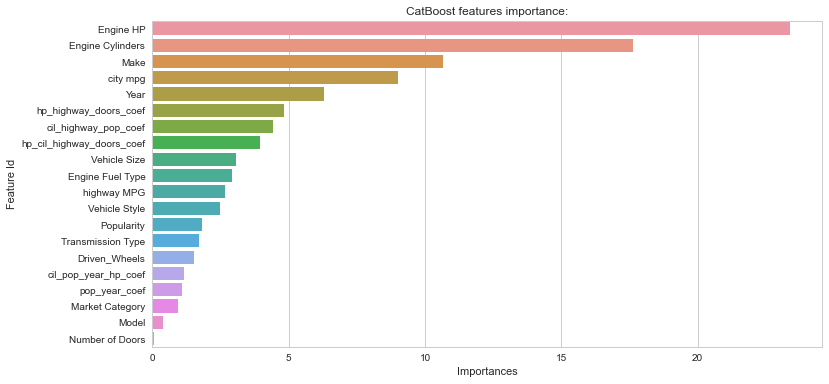

In [485]:
df_feat_imp = ctb_feature_importance(pipeline.steps[1][1])

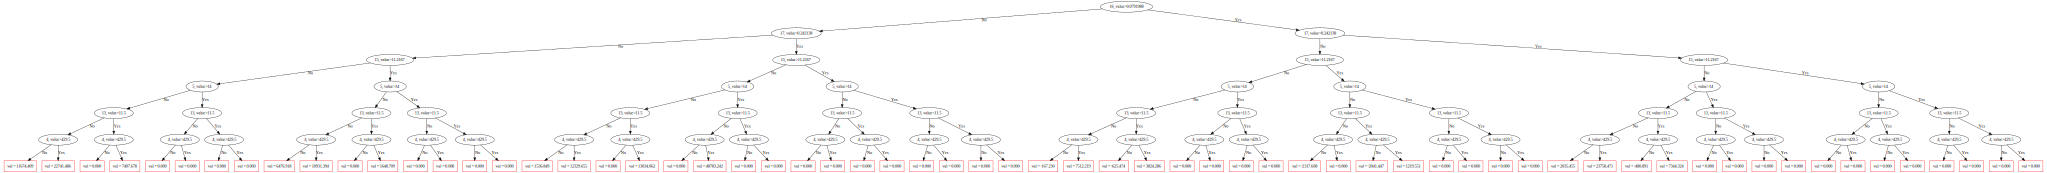

In [486]:
#Visualize the CatBoost decision trees
pipeline.steps[1][1].plot_tree(tree_idx=0)

7. Сохраните вашу модель на диск

In [503]:
with open("hw8_pipeline_model2.dill", "wb") as f:
    dill.dump(pipeline, f)